# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- 02-07-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer in the LSTM is optionally initialized with either GloVe or FastText Embeddings.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from src.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import src.metrics as metrics

In [5]:
import collections
import functools
import six
import time
import string

import tqdm
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU, unless GPU isn't available (which is the case for me)

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 10
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

USE_PRETRAINED_EMBEDDING = True
EMBEDDING_DIM = 300
#EMBEDDING_PATH = f'../word_embeddings/glove/glove.6B.{EMBEDDING_DIM}d.txt'
EMBEDDING_PATH = f'../word_embeddings/fasttext/wiki-news-{EMBEDDING_DIM}d-1M.vec'
#EMBEDDING_PATH = f'../word_embeddings/fasttext/crawl-{EMBEDDING_DIM}d-2M.vec'


RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

In [18]:
def load_fasttext_embeddings():
    
    """
    Code modified from: https://fasttext.cc/docs/en/english-vectors.html.
    """
    
    fin = io.open(EMBEDDING_PATH, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = [int(x) for x in fin.readline().split()]
    
    embeddings_index = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        embeddings_index[tokens[0]] = np.array([float(x) for x in tokens[1:]])
        
    return embeddings_index

In [19]:
def load_glove_embeddings():
    
    """
    Code modified from: https://keras.io/examples/pretrained_word_embeddings/.
    """
    
    embeddings_index = {}
    with open(EMBEDDING_PATH, 'r') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
            
    return embeddings_index

### Create Embedding Matrix from Words in Word Index and Word Embeddings
Words with no embedding are initialized according to the random uniform distribution used by the tf.keras embedding layer.

In [20]:
def create_matrix_from_pretrained_embeddings(embedding_fn, word2idx):
                                             
    """
    Code modified from: https://keras.io/examples/pretrained_word_embeddings/.
    Here we initialize the embedding matrix to random uniform values according
    to the random uniform initializer in tf.keras used by tf.keras.layers.Embedding.
    This way any words without embeddings are mapped according to this random
    distribution and can then be learned.
    """
    
    embeddings_index = embedding_fn()
    
    em_init_params = tf.random_uniform_initializer().get_config()
    embedding_matrix = np.random.uniform(low=em_init_params['minval'],
                                         high=em_init_params['maxval'],
                                         size=(EXTENDED_VOCAB_SIZE, EMBEDDING_DIM))
    
    missing_words = 0
    for word, i in word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None:
            missing_words += 1
        else:
            embedding_matrix[i] = embedding_vector
            
    print(f'Words from dataset with no embedding: {missing_words}')
    
    return tf.keras.initializers.Constant(embedding_matrix)

In [21]:
if USE_PRETRAINED_EMBEDDING:
    EMBEDDING_MATRIX =  create_matrix_from_pretrained_embeddings(embedding_fn=load_fasttext_embeddings,
                                                                 word2idx=word2idx)
else:
    EMBEDDING_MATRIX = 'uniform'

Words from dataset with no embedding: 922


### Define Function to Build Model

In [22]:
def build_model():
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ),
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 embeddings_initializer=EMBEDDING_MATRIX,
                                                 mask_zero=True,
                                                 trainable=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [23]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], 1)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' ' + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [24]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you today directx subjective favorite lang companies birth delegated unneeded clarification communicates cmake shows propagate conditional non-static explored ienumerable offending border disaster whatsoever jetty lay inspection non-working echoed east thereby markers board user's recipes strips packing review item1 amd xib pk brilliant twice operation pressed populate preview ds expiration come policies showdialog


### Define Evaluation Metrics for Training

In [25]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [26]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [27]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [28]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [29]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [30]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [31]:
def keras_evaluate(state, val_dataset):
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [32]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [33]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [34]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [35]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [36]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [37]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 31s 312ms/step - loss: 6.3697 - num_tokens: 131037.0000 - num_tokens_no_oov: 126506.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.8157e-05 - accuracy_no_oov: 3.9524e-05 - accuracy_no_oov_no_eos: 4.2041e-05
Sampling 10 new clients.
Round: 0
   Loss: 6.51340151
   num_batches: 259
   num_examples: 4062
   num_tokens: 58806
   num_tokens_no_oov: 57152
   accuracy: 0.01206
   accuracy_no_oov: 0.01241
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 318ms/step - loss: 6.5669 - num_tokens: 136004.0000 - num_tokens_no_oov: 131489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0051 - accuracy_no_oov: 0.0052 - accuracy_no_oov_no_eos: 0.0055
Sampling 10 new clients.
Round: 1
   Loss: 5.62639761
   num_batches: 294
   num_examples: 4641
   num_tokens: 60789
   num_tokens_no_oov: 59107
   accuracy: 0.02069
   accuracy_no_oov: 0.02128
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 33s 334ms/step - loss: 6.4950 - num_tokens: 134420.0000 - num_tokens_no_oov: 130459.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.4394e-05 - accuracy_no_oov: 7.6652e-05 - accuracy_no_oov_no_eos: 8.1256e-05
Sampling 10 new clients.
Round: 2
   Loss: 5.32292986
   num_batches: 350
   num_examples: 5521
   num_tokens: 77723
   num_tokens_no_oov: 75433
   accuracy: 0.03029
   accuracy_no_oov: 0.03082
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 34s 341ms/step - loss: 6.2617 - num_tokens: 129887.0000 - num_tokens_no_oov: 125546.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 5.79715490
   num_batches: 180
   num_examples: 2825
   num_tokens: 38214
   num_tokens_no_oov: 37072
   accuracy: 0.01031
   accuracy_no_oov: 0.01063
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 33s 328ms/step - loss: 6.3067 - num_tokens: 131954.0000 - num_tokens_no_oov: 128255.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 5.53495646
   num_batches: 193
   num_examples: 3021
   num_tokens: 39903
   num_tokens_no_oov: 38921
   accuracy: 0.00717
   accuracy_no_oov: 0.00735
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 321ms/step - loss: 6.2135 - num_tokens: 131895.0000 - num_tokens_no_oov: 127793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 4.62311029
   num_batches: 203
   num_examples: 3180
   num_tokens: 38054
   num_tokens_no_oov: 37020
   accuracy: 0.02176
   accuracy_no_oov: 0.02237
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 315ms/step - loss: 5.9290 - num_tokens: 129287.0000 - num_tokens_no_oov: 124015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 4.67391396
   num_batches: 179
   num_examples: 2785
   num_tokens: 33460
   num_tokens_no_oov: 32442
   accuracy: 0.01285
   accuracy_no_oov: 0.01325
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 315ms/step - loss: 5.9644 - num_tokens: 135754.0000 - num_tokens_no_oov: 131634.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 5.15162992
   num_batches: 137
   num_examples: 2138
   num_tokens: 27780
   num_tokens_no_oov: 26899
   accuracy: 0.00086
   accuracy_no_oov: 0.00089
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 324ms/step - loss: 5.4472 - num_tokens: 129112.0000 - num_tokens_no_oov: 125449.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 4.88334322
   num_batches: 195
   num_examples: 3037
   num_tokens: 42111
   num_tokens_no_oov: 40795
   accuracy: 0.01479
   accuracy_no_oov: 0.01525
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 32s 319ms/step - loss: 5.3952 - num_tokens: 134913.0000 - num_tokens_no_oov: 129999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 5.21005011
   num_batches: 140
   num_examples: 2144
   num_tokens: 30863
   num_tokens_no_oov: 29942
   accuracy: 0.00094
   accuracy_no_oov: 0.00060


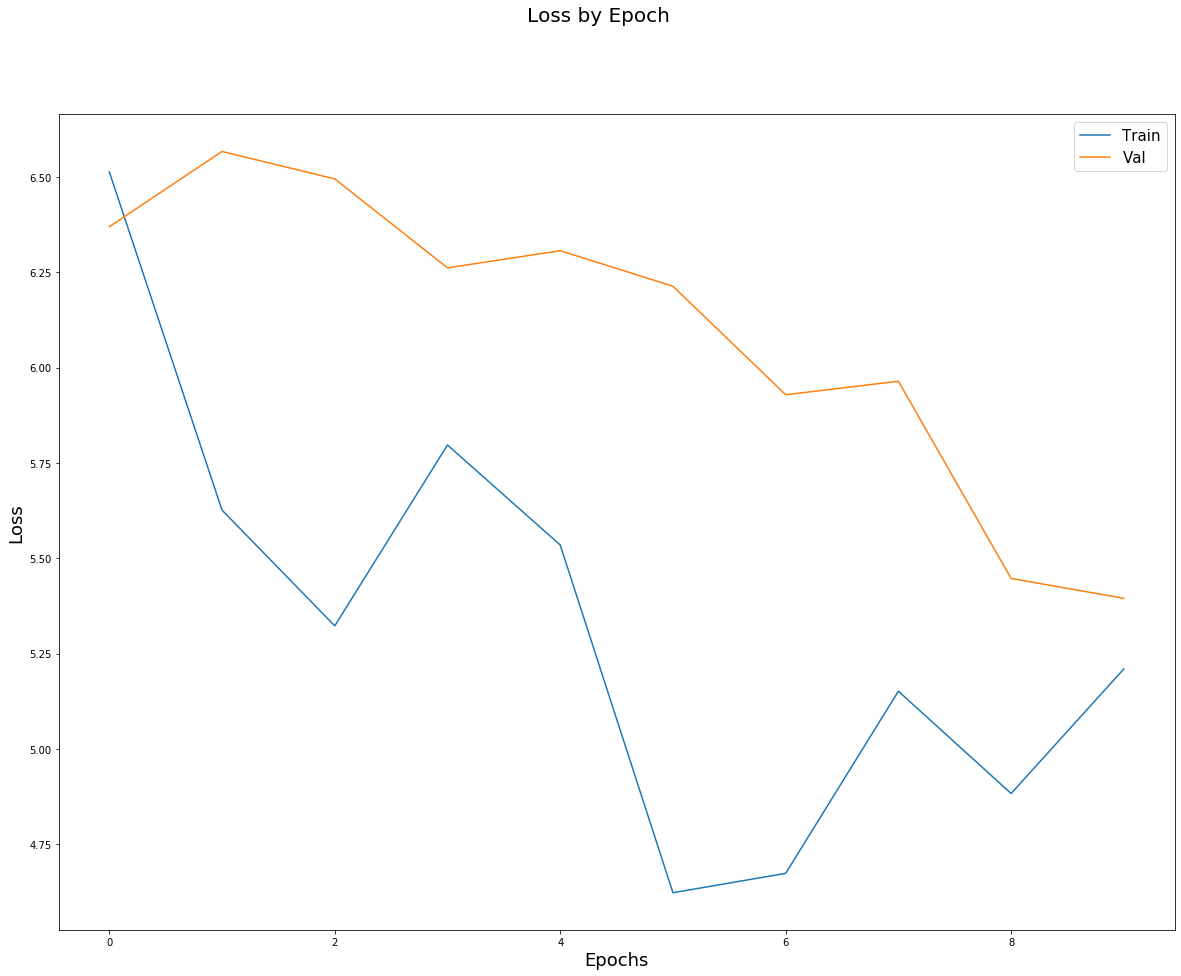

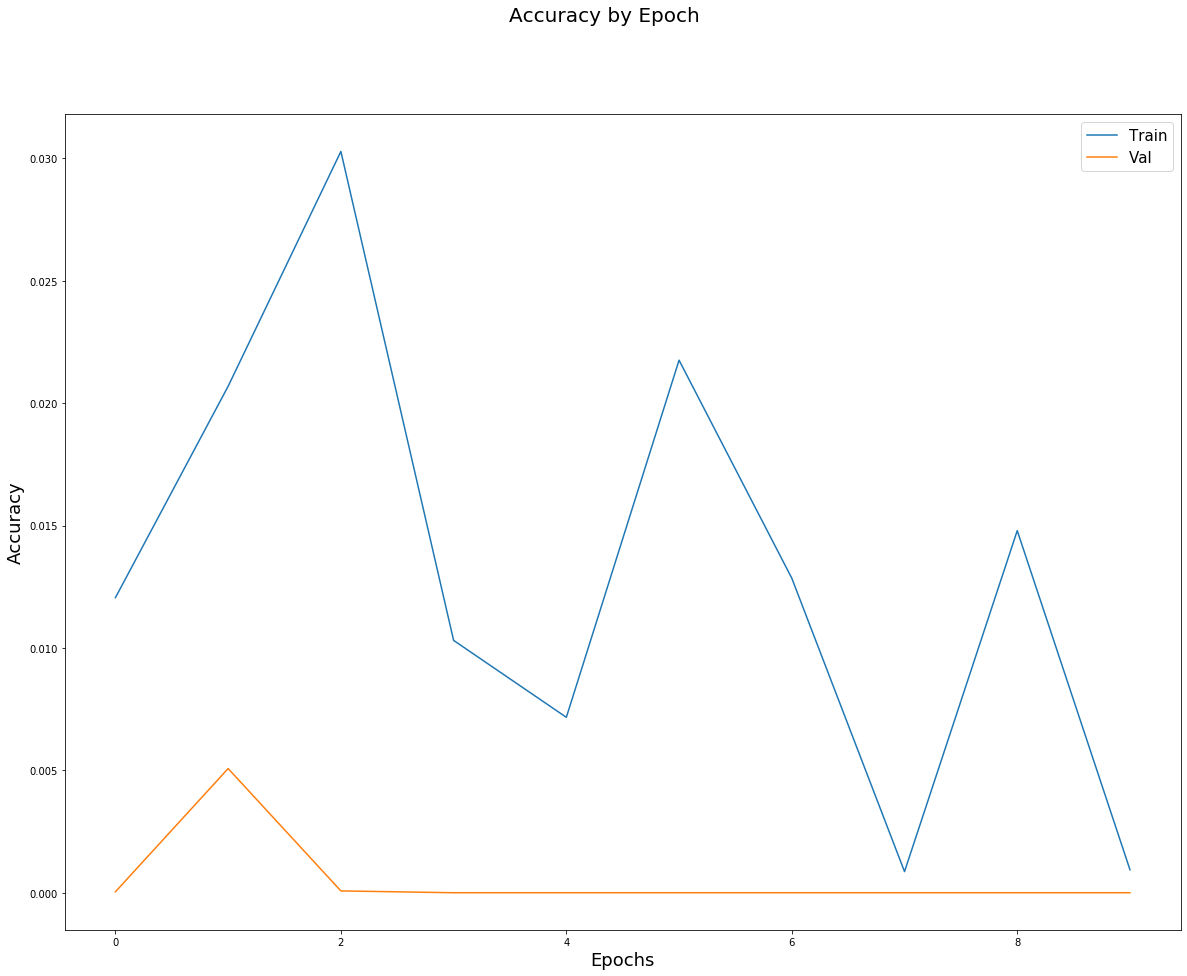

In [39]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        keras_evaluate(server_state, val_data)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        # Save loss and accuracy from train and validation sets
        np.save('train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save('train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))

except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

### Load Loss and Accuracy Arrays

In [ ]:
# train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
# train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
# val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
# val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Compare Model Loss

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 15))
# x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
# ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
# ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Train with Glove')
# ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Val with Glove')
# ax.legend(loc='best', prop={'size': 15})
# fig.suptitle('Model\'s Loss with number of epochs', fontsize=20)
# plt.xlabel('Epochs', fontsize=18)
# plt.ylabel('Loss', fontsize=18)
# fig.savefig('Loss_with_Epochs.jpg')
# plt.show()

### Compare Model Accuracy

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 15))
# x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
# ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
# ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Train with Glove')
# ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Val with Glove')
# ax.legend(loc='best', prop={'size': 15})
# fig.suptitle('Model\'s Accuracy with number of epochs', fontsize=20)
# plt.xlabel('Epochs', fontsize=18)
# plt.ylabel('Accuracy', fontsize=18)
# fig.savefig('Accuracy_with_Epochs.jpg')
# plt.show()